# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.offline as py
from google.colab import data_table
!pip install openpyxl
data_table.enable_dataframe_formatter()
template_style = "plotly_dark"
%matplotlib inline

In [2]:
df = pd.read_excel('basededatos.xlsx')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278649 entries, 0 to 278648
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Fecha                        278649 non-null  datetime64[ns]
 1   apat                         278466 non-null  object        
 2   amat                         271958 non-null  object        
 3   nombre                       278633 non-null  object        
 4   tiempo_espera_triage         278579 non-null  float64       
 5   tiempo_en_triage             278579 non-null  float64       
 6   tiempo_espera_despuestriage  277192 non-null  float64       
 7   tiempo_en_consulta           277180 non-null  float64       
 8   clasificacion                278649 non-null  object        
 9   edad                         278649 non-null  int64         
 10  Edad1                        278649 non-null  object        
 11  Dx                        

##### Remove duplicates and null values  

In [3]:
# the porcentage of missing values is   10,999 - 3.9%
# the porcentage of duplicates is       9,160  - 3.3%
df_without_duplicates = df.drop_duplicates()
df_without_duplicates_and_na = df_without_duplicates.dropna()
# 19008 data removed

##### Convert values to absolute values

In [4]:
df_absolut_values = df_without_duplicates_and_na.copy()
df_absolut_values['tiempo_espera_triage'] = df_without_duplicates_and_na['tiempo_espera_triage'].abs()
df_absolut_values['tiempo_en_triage'] = df_without_duplicates_and_na['tiempo_en_triage'].abs()
df_absolut_values['tiempo_espera_despuestriage'] = df_without_duplicates_and_na['tiempo_espera_despuestriage'].abs()
df_absolut_values['tiempo_en_consulta'] = df_without_duplicates_and_na['tiempo_en_consulta'].abs()
df_absolut_values['edad'] = df_without_duplicates_and_na['edad'].abs()

# create a column with the total time
df_absolut_values['tiempo_total'] = df_absolut_values['tiempo_espera_triage'] + df_absolut_values['tiempo_en_triage'] + df_absolut_values['tiempo_espera_despuestriage'] + df_absolut_values['tiempo_en_consulta']

##### Outliers for 'tiempo_total' (IQR) interquartile range


In [5]:
# Calculate the percentiles
twenty_fifth = df_absolut_values['tiempo_total'].quantile(0.25)
seventy_fifth = df_absolut_values['tiempo_total'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset
outliers = df_absolut_values[(df_absolut_values['tiempo_total'] < lower) | (df_absolut_values['tiempo_total'] > upper)]

print(f'Number of outliers: {len(outliers)}')

# the porcentage of 'tiempo_total' outliers is      726 - 0.2%
df_without_outliers = df_absolut_values.drop(outliers.index)

Number of outliers: 12265


Text(0.5, 0, 'Total wating time')

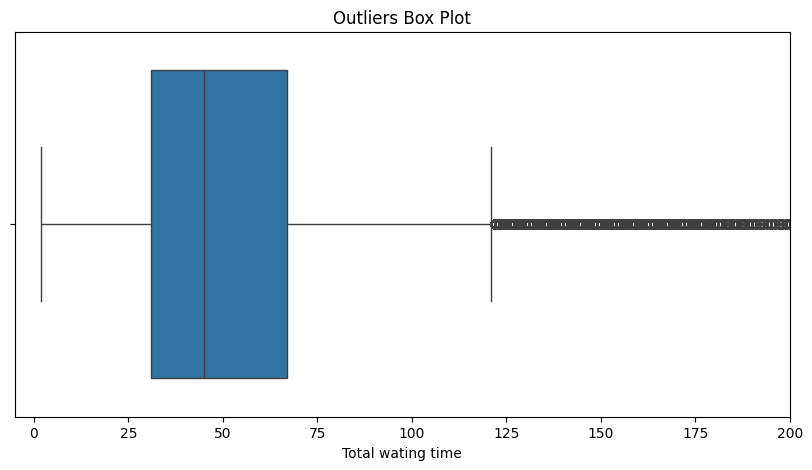

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Create a box plot
g = sns.boxplot(data=df_absolut_values, x='tiempo_total')
plt.xlim(-5, 200)

# Add a title and change xlabel
g.set_title('Outliers Box Plot')
g.set_xlabel('Total wating time')

##### Standardize the value of the age

In [7]:
df_cleaning_edad = df_without_outliers.copy()
df_cleaning_edad.rename(columns={'Edad1': 'edad_unidad'}, inplace=True)
# convert column edad_unidad to numeric.
df_cleaning_edad['edad_unidad'] = df_cleaning_edad['edad_unidad'].replace({'Años': 1, 'Meses': 1/12, 'Dias': 1/365})
# standardize the value of the age
df_cleaning_edad['edad'] = df_cleaning_edad['edad'] * df_cleaning_edad['edad_unidad']

##### Outliers for 'edad' (IQR)

In [8]:
df_cleaning_edad = df_cleaning_edad.copy()
twenty_fifth = df_cleaning_edad['edad'].quantile(0.25)
seventy_fifth = df_cleaning_edad['edad'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset
outliers_edad = df_cleaning_edad[(df_cleaning_edad['edad'] < lower) | (df_cleaning_edad['edad'] > upper)]

print(f'Number of outliers: {len(outliers_edad)}')

# the porcentage of 'edad' outliers is      3 - 0.001%
df_without_outliers_edad = df_cleaning_edad.drop(outliers_edad.index)

Number of outliers: 3


Text(0.5, 0, 'Age')

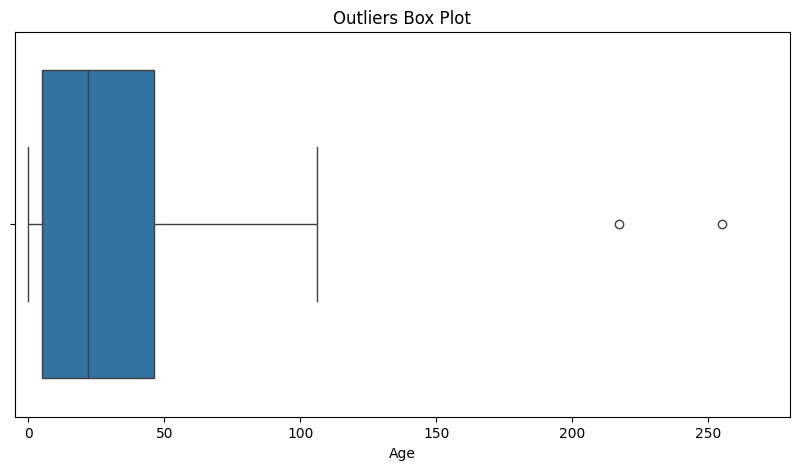

In [9]:
plt.figure(figsize=(10, 5))

# Create a box plot
g = sns.boxplot(data=df_cleaning_edad, x='edad')
plt.xlim(-5, 280)

# Add a title and change xlabel
g.set_title('Outliers Box Plot')
g.set_xlabel('Age')

##### Obtain gender

In [10]:
!pip install gender_guesser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 5.7 MB/s eta 0:00:00


In [11]:
df_gender_detector = df_without_outliers_edad.copy()
import gender_guesser.detector as gender

# Create an gender detector object
d = gender.Detector()

def obtener_genero(nombre):
    # setting the second name, there is a total categorization between 'Ambiguo' y 'Desconocido' of 34,535 names
    nombre = nombre.split()[-1]
    nombre = nombre.title()
    # if the name is 'Femenino' or 'Masculino' return the name
    # total categorization between 'Ambiguo' y 'Desconocido' of 27,709 names. Recover 6,826 names
    if nombre == 'Femenino' or nombre == 'Masculino':
        return nombre
    else:
        return d.get_gender(nombre)

df_gender_detector['genero'] = df_gender_detector['nombre'].apply(obtener_genero)

df_gender_detector['genero'] = df_gender_detector['genero'].replace({
    'male': 'Masculino',
    'female': 'Femenino',
    'andy': 'Ambiguo',
    'unknown': 'Desconocido',
    'mostly_male': 'Masculino',
    'mostly_female': 'Femenino'
})

##### Remove 'Ambiguio' and 'Desconocido' values

In [12]:
df_gender_detector_ambiguo = df_gender_detector[(df_gender_detector['genero'] == 'Ambiguo') | (df_gender_detector['genero'] == 'Desconocido')]

print(f'Number of unknown: {len(df_gender_detector_ambiguo)}')
# the porcentage of 'df_gender_detector_ambiguo' is      27,709 - 9.9%
df_gender_detector_clean = df_gender_detector.drop(df_gender_detector_ambiguo.index)

Number of unknown: 25817


##### Encode gender and clasification

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Encode calsification of triage
df_encode = df_gender_detector_clean.copy()
# Encode clasification 'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2
df_encode['clasificacion_encode'] = df_encode['clasificacion'].replace({'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2})

encoder = OneHotEncoder(sparse_output=False)
# Aplicar el codificador a la columna 'genero'
genero_encoded = encoder.fit_transform(df_encode[['genero']])
# Convertir la salida a un DataFrame
genero_encoded_df = pd.DataFrame(genero_encoded, columns=encoder.get_feature_names_out(['genero']), index=df_encode.index)
# Concatenar las columnas codificadas con el DataFrame original
df_encode = pd.concat([df_encode, genero_encoded_df], axis=1)

##### Caracteristics from Date

In [14]:
df_date = df_encode.copy()
# Extract caracteristics from date
df_date['hora'] = df_date['Fecha'].dt.hour
df_date['minuto'] = df_date['Fecha'].dt.minute
df_date['mes'] = df_date['Fecha'].dt.month
df_date['dia'] = df_date['Fecha'].dt.day
df_date['dia_semana'] = df_date['Fecha'].dt.dayofweek

##### Correlation

In [15]:
df_corr = df_date.copy()
df_corr.drop(columns=['nombre', 'apat', 'amat', 'Fecha', 'Dx', 'edad_unidad', 'genero', 'clasificacion', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta'], inplace=True)
corr = df_corr.corr()

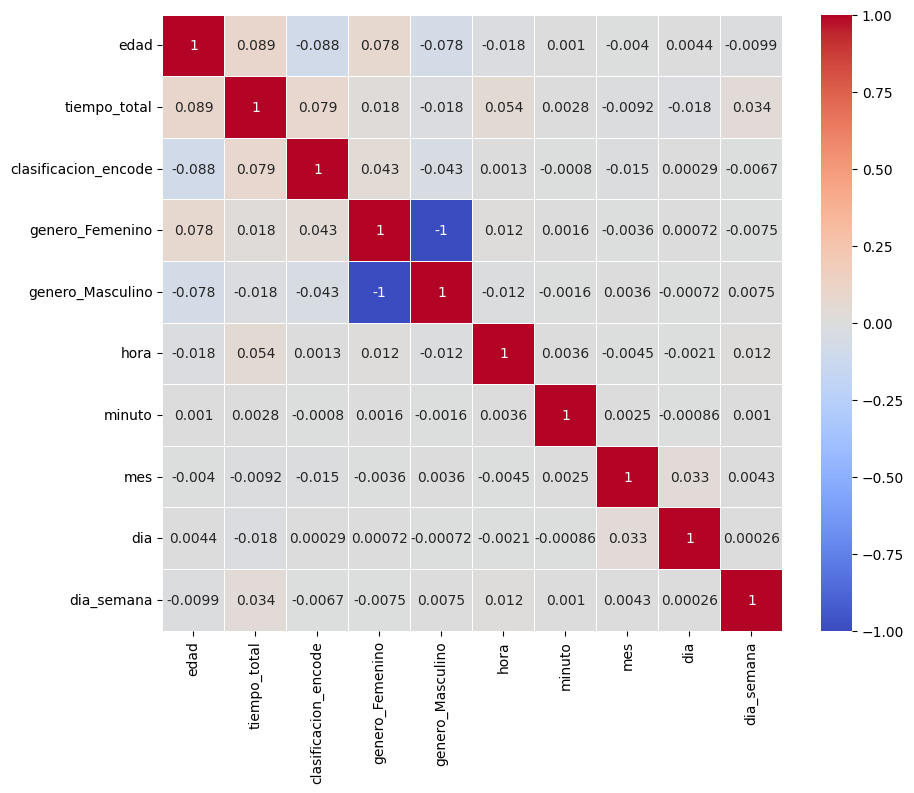

In [16]:
# Crear el mapa de calor
plt.figure(figsize=(10, 8))  # Definir el tamaño de la figura
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)

# Mostrar el gráfico
plt.show()

##### Removal of Punctuations

In [36]:
df_clean_text = df_date.copy()

In [42]:
import string

# clean text
# the porcentage of not string values is %
df_not_string = df_clean_text[~df_clean_text['Dx'].apply(lambda x: isinstance(x, str))]
df_clean_text = df_clean_text.drop(df_not_string.index)

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', string.punctuation + '1' + '2' + '3'))

df_clean_text['Dx'] = df_clean_text['Dx'].apply(lambda text: remove_punctuation(text))

##### Remove empty string

In [43]:
df_empty_string = df_clean_text[df_clean_text['Dx'] == '']
print(f'Number of empty string: {len(df_empty_string)}')

df_without_empty_str = df_clean_text.drop(df_empty_string.index)

Number of empty string: 1171


##### Embeddings

In [45]:
df_regresion = df_without_empty_str.copy()

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Create a TaggedDocument object
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df_regresion['Dx'])]

# Create a Doc2Vec model
model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=40)

df_regresion['doc2vec'] = [model.dv[str(i)] for i in range(len(tagged_data))]


In [ ]:
df_doc2vec = pd.DataFrame(df_regresion['doc2vec'].tolist(), index=df_regresion.index)
X_doc2vec = pd.concat([df_regresion.drop('doc2vec', axis=1), df_doc2vec], axis=1)
X_doc2vec.drop(columns=['nombre', 'apat', 'amat', 'Fecha', 'Dx', 'edad_unidad', 'genero', 'clasificacion', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta', 'tiempo_total'], inplace=True)
# 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta',

In [ ]:
# convert X_doc2vec to csv file
X_doc2vec.to_csv('./prediction_feature.csv', index=False)
df_regresion['tiempo_total'].to_csv('./target.csv', index=False)

In [ ]:
X_doc2vec.head()

,edad,clasificacion_encode,genero_Femenino,genero_Masculino,hora,minuto,mes,dia,dia_semana,0,...,90,91,92,93,94,95,96,97,98,99
0,42.0,1,0.0,1.0,8,46,8,16,0,-0.088107,...,-0.283992,0.075685,0.060538,0.284567,0.128691,-0.013482,0.184059,-0.047906,-0.031753,-0.178103
1,45.0,1,1.0,0.0,9,0,8,16,0,0.061355,...,-0.095451,0.196688,0.037411,-0.009080,0.141159,0.246847,-0.061491,-0.172121,0.133039,0.004996
7,33.0,1,1.0,0.0,9,44,8,16,0,-0.123947,...,-0.100632,-0.198273,-0.443305,0.188409,-0.225076,-0.232133,-0.274741,-0.035126,-0.076651,0.298023
9,4.0,1,0.0,1.0,9,59,8,16,0,0.081780,...,0.004751,-0.070866,-0.146901,-0.075094,-0.059237,0.084469,0.058776,0.044242,0.023129,0.006029
10,48.0,1,1.0,0.0,11,13,8,16,0,0.004022,...,0.004578,0.023451,0.009109,0.006576,0.062764,0.043072,-0.011790,-0.010112,-0.019141,0.026250


# Regression Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Select target and features
# X = df_regresion[['clasificacion_encode', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
X = pd.read_csv('./evaluation_feature.csv')
y = pd.read_csv('./target.csv')
y = y.values.ravel()

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Root Mean Squared Error (RMSE): 2.665875042253212
Mean Squared Error (MSE): 7.106889740908563
Coeficiente de determinación (R^2): 0.9875161795099878
Mean Absolute Error (MAE): 1.7731846171720693
   Actual  Predicted
0    67.0       63.0
1    22.0       22.0
2    23.0       23.0
3    21.0       21.0
4    49.0       50.0
5    54.0       53.0
6    35.0       33.0
7    85.0       85.0
8    27.0       29.0
9    40.0       43.0


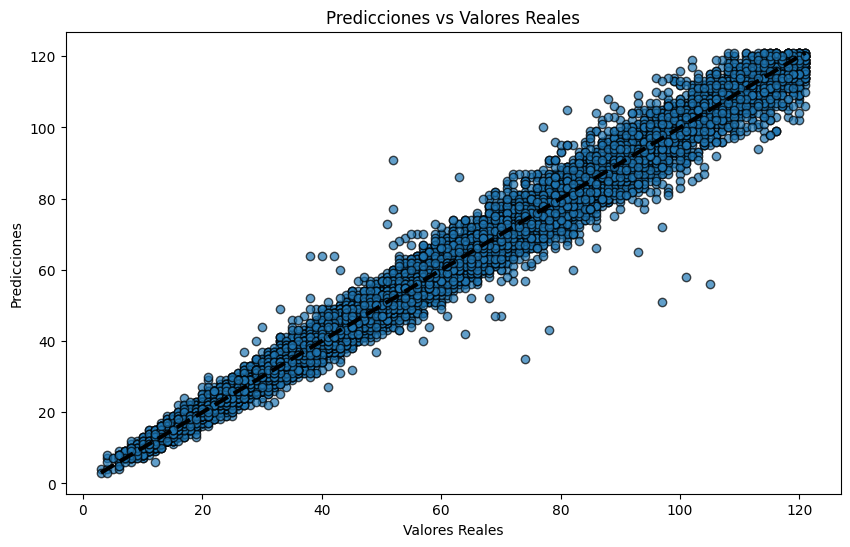

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Predictions
y_test_pred = model.predict(X_test)

# Métricas de evaluación
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_test_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()


# ANN Model

In [ ]:
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
import numpy as np

# Dividir los datos en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Configurar la semilla para reproducibilidad
np.random.seed(3000)

# Construcción de la red neuronal
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense (512, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense(1))

# Inicializar el optimizador con una tasa de aprendizaje inicial
initial_learning_rate = 0.01
optimizer = RMSprop(learning_rate=initial_learning_rate)
#MSprop (Root Mean Square Propagation) es una extensión del método de descenso del gradiente estocástico (SGD)
#que ajusta la tasa de aprendizaje para cada parámetro de forma individual
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Entrenar el modelo
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr, model_checkpoint, early_stopping])

# Evaluación del modelo
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Mean Absolute Error on test data: {mae}')

Epoch 1/100
8605/8607 [============================>.] - ETA: 0s - loss: 1933.9736 - mae: 20.5430
Epoch 1: val_loss improved from inf to 586.95038, saving model to best_model.keras
8607/8607 [==============================] - 51s 6ms/step - loss: 1933.7205 - mae: 20.5434 - val_loss: 586.9504 - val_mae: 18.8266 - lr: 0.0100
Epoch 2/100
8600/8607 [============================>.] - ETA: 0s - loss: 579.3505 - mae: 19.1495
Epoch 2: val_loss improved from 586.95038 to 557.47839, saving model to best_model.keras
8607/8607 [==============================] - 50s 6ms/step - loss: 579.4205 - mae: 19.1503 - val_loss: 557.4784 - val_mae: 18.9508 - lr: 0.0100
Epoch 3/100
8603/8607 [============================>.] - ETA: 0s - loss: 572.7313 - mae: 19.0878
Epoch 3: val_loss did not improve from 557.47839
8607/8607 [==============================] - 50s 6ms/step - loss: 572.7995 - mae: 19.0889 - val_loss: 567.9893 - val_mae: 19.3599 - lr: 0.0100
Epoch 4/100
8602/8607 [============================>.] - 

1345/1345 [==============================] - 3s 2ms/step
Root Mean Squared Error (RMSE): 23.477181757886118
Mean Squared Error (MSE): 551.1780632928206
Coeficiente de determinación (R^2): 0.03181162913320923
Mean Absolute Error (MAE): 18.776141890867866
   Actual  Predicted
0    67.0  45.853416
1    22.0  51.804272
2    23.0  45.853416
3    21.0  45.853416
4    49.0  45.938068
5    54.0  53.569138
6    35.0  45.853416
7    85.0  47.230762
8    27.0  53.569138
9    40.0  49.358681


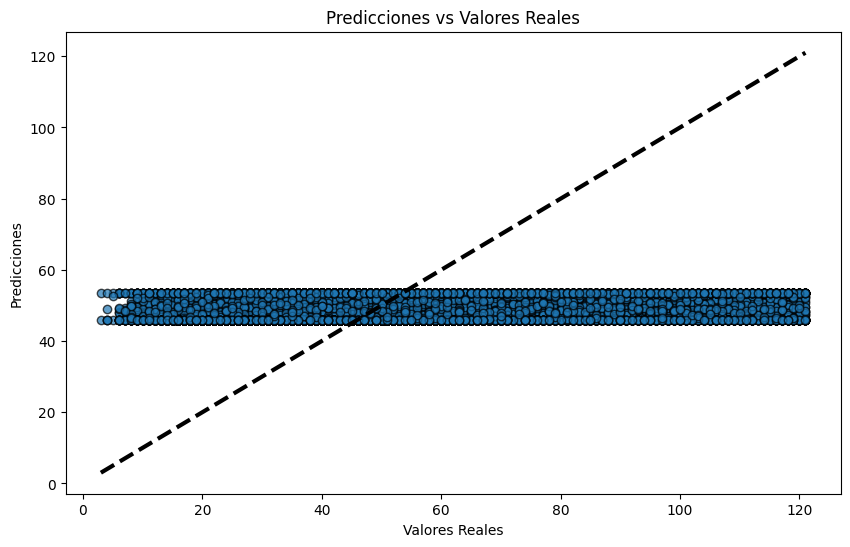

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


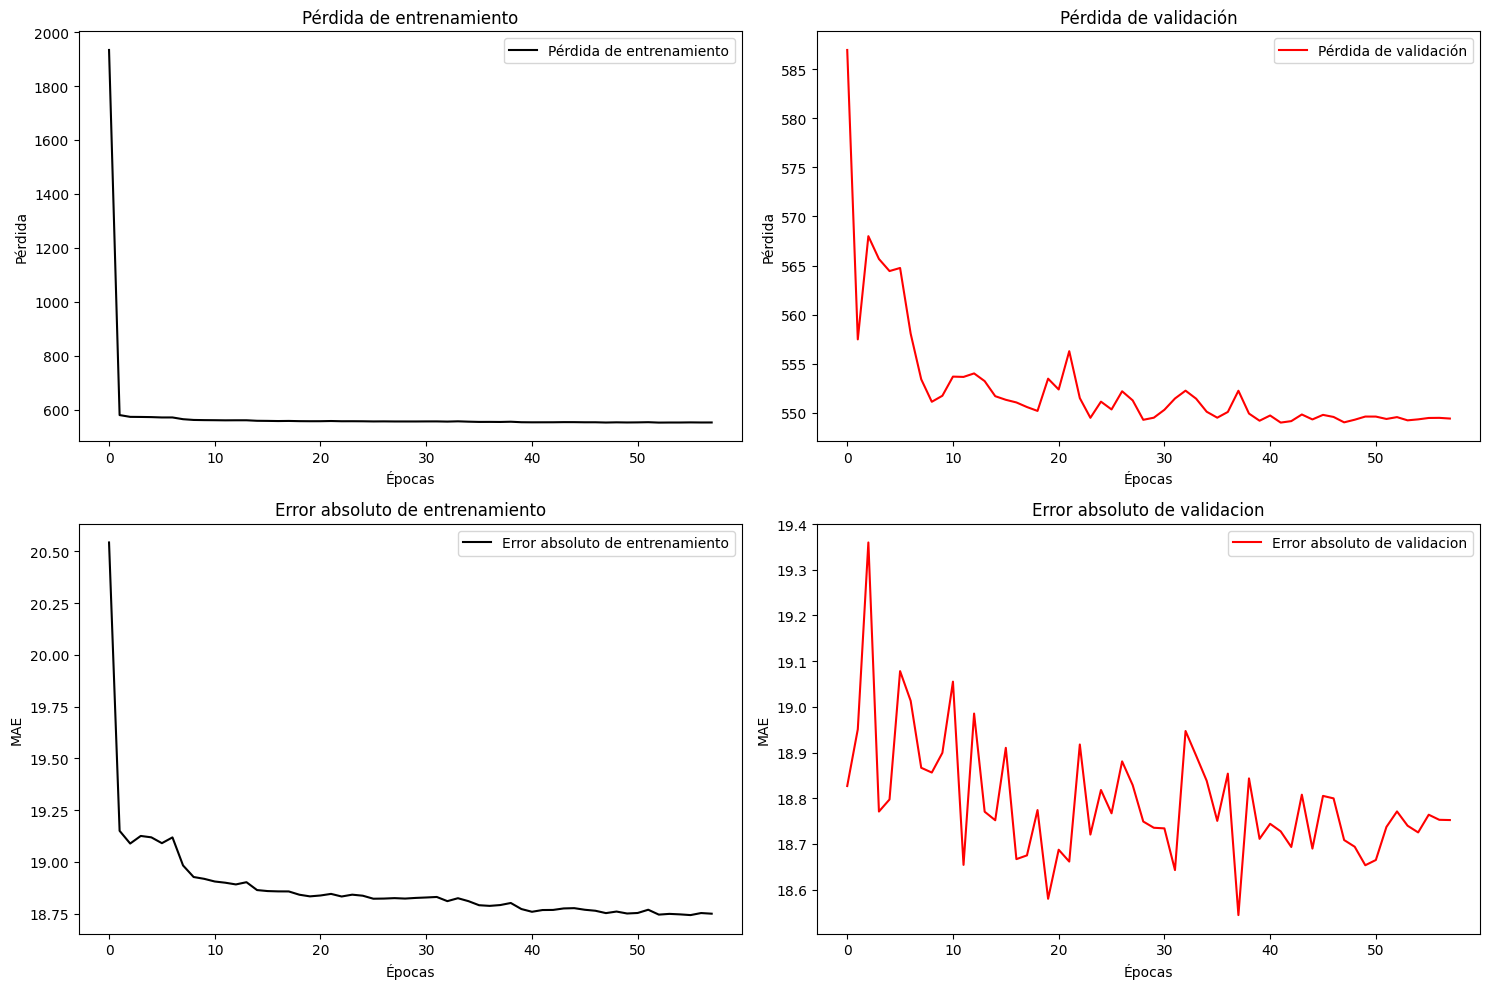

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Predicción
y_pred = model.predict(X_test)


# Métricas de evaluación
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

# Imprimir las claves de history.history
print(history.history.keys())

import matplotlib.pyplot as plt


# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Graficar la pérdida de entrenamiento
axs[0, 0].plot(history.history['loss'], label='Pérdida de entrenamiento', color="black")
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Pérdida')
axs[0, 0].set_title('Pérdida de entrenamiento')
axs[0, 0].legend()

# Graficar la pérdida de validación
axs[0, 1].plot(history.history['val_loss'], label='Pérdida de validación',color="red")
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Pérdida')
axs[0, 1].set_title('Pérdida de validación')
axs[0, 1].legend()

# Graficar MAE de entrenamiento
axs[1, 0].plot(history.history['mae'], label='Error absoluto de entrenamiento', color="black")
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_title('Error absoluto de entrenamiento')
axs[1, 0].legend()

# Graficar MAE de validación
axs[1, 1].plot(history.history['val_mae'], label='Error absoluto de validacion', color="red")
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].set_title('Error absoluto de validacion')
axs[1, 1].legend()

# Ajustar diseño para evitar solapamiento
plt.tight_layout()
plt.show()

# Analisys

##### Prepare data

In [ ]:
df_analisys = df_encode.copy()

In [ ]:
df_analisys.rename(columns={'Fecha':'date'}, inplace=True)

df_analisys['entry_time'] = df_analisys['date'].dt.time
df_analisys['entry_time'] = pd.to_timedelta(df_analisys.entry_time.astype(str))


df_analisys.rename(columns={'tiempo_total':'waiting_time'}, inplace=True)
df_analisys['waiting_time'] = pd.to_timedelta(df_analisys['waiting_time'], unit='m')

df_analisys['completion_time'] = df_analisys['waiting_time'] + df_analisys['entry_time']

df_analisys['waiting_ber_munets'] = df_analisys.waiting_time.dt.seconds / 60
df_analisys['waiting_ber_munets'] = df_analisys['waiting_ber_munets'].round(0)

df_analisys['weekday'] = df_analisys.date.dt.strftime('%A')                      # new column for extract 'weekday' from 'date'
df_analisys['hours'] = df_analisys.entry_time.dt.components.hours                # new column for extract the  'hours' from 'entry_time'

In [ ]:
df_analisys.dtypes

In [ ]:
df_analisys.drop(columns=['nombre', 'genero', 'Dx'], inplace=True)
df_analisys.head(2)

##### Patient heatmap

In [ ]:

def grouped_data2(column_name):
    if column_name == 'completion_time':
        answer = pd.pivot_table(df_analisys, index='hours', columns=['weekday'], aggfunc='count')
    elif column_name == 'waiting_ber_munets':
        answer = pd.pivot_table(df_analisys, index='hours',
                                columns=['weekday'] , aggfunc='mean').round(1)
    else:
        return(column_name + " is not in the columns")

    answer = answer[column_name]
    answer = answer.fillna(0)
    answer = answer[['Sunday', 'Monday', 'Tuesday',
                  'Wednesday', 'Thursday',
                  'Friday', 'Saturday']]
    return answer
answer3 =  grouped_data2('completion_time')
answer4 =  grouped_data2('waiting_ber_munets')
print(answer3,answer4)

In [ ]:
fig3 = px.imshow(answer3,
                labels=dict(x="weekday", y="hours", color="number of paitant") ,
                aspect="auto", color_continuous_scale='tempo',
                template = template_style,
                text_auto=True, width=900, height=900)
fig3.update_xaxes(side="top")
fig3.show()

##### Hour heatmap

In [ ]:
fig4 = px.imshow(answer4,
                labels=dict(x="weekday", y="hours",
                            color="the waiting time per min") ,
                            aspect="auto", color_continuous_scale='tempo',
                            template = template_style,
                            text_auto=True, width=900, height=900)
fig4.update_xaxes(side="top")
fig4.show()

##### Bar chart

In [ ]:
def grouped_data(column_name):
    '''
    Groupby column and return DataFrame
    Input: Column Name
    '''
    df_tmp = df_analisys.groupby(column_name)[['waiting_ber_munets']].mean().round(0)
    df_tmp2 = df_analisys[column_name].value_counts()      #this for concat

    pivot_f = pd.concat([df_tmp, df_tmp2.rename('number_of_patient')],axis=1)
    pivot_f.reset_index(inplace=True)
    pivot_f = pivot_f.rename(columns={'index': column_name })
    return pivot_f

answer5 = grouped_data('hours')
link_size = [3,6]
fig = px.bar(x=answer5['hours'],
             y=answer5['waiting_ber_munets'],
             template= template_style,
             text_auto='.2s',
             labels={'x':'the hour',
                     'y':'the waiting time per m'}
             ).add_traces(
      px.line(answer5, x=answer5['hours'], text='number_of_patient',
             y=answer5['number_of_patient'],markers=True).update_traces(yaxis="y2",
             showlegend=True, line=dict(color = 'red', width=link_size[1]), name="number_of_patient").data)
fig.update_layout(yaxis2={"side":"right", "overlaying":"y"})
fig.show()

##### Weekly chart

In [ ]:
answer2 =  grouped_data('weekday')
# Create Chart for the Daily
fig2 = px.bar(answer2,
             x='weekday',
             y='number_of_patient',
             color='waiting_ber_munets',
             labels={'waiting_ber_munets':'the waiting time per m'} ,
             color_continuous_scale=['green','yellow','red'],
             template = template_style,
             title = '<b>Daily visualization</b>')
# Display Plot
fig2.show()

# Results